## Importing libraries

In [1]:
import pandas as pd
import numpy as np
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import time
from tqdm import tqdm_notebook

In [2]:
import gcsfs

In [3]:
import glob

In [4]:
import pyarrow

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [8]:
import seaborn as sns

In [6]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [7]:
import dask.dataframe as dd

In [31]:
from fbprophet import Prophet

In [156]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

In [33]:
pd.plotting.register_matplotlib_converters()

## Importing data

In [11]:
cluster = LocalCluster(processes=True, n_workers=4)
client = Client(cluster)

In [13]:
dask.__version__

'2.8.0'

In [14]:
gcs = gcsfs.GCSFileSystem()

In [15]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-11.parquet',
 'gcs://ny

In [16]:
%time data_hr_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 874 ms


# Time series forecasting - Facebook Prophet

In [19]:
def acc(y_actual,y_predicted):
    y_predicted = np.array(y_predicted)
    y_actual = np.array(y_actual)
    return 1 - (sum([abs((float(y_pred) - float(y_act))/float(y_act)) for y_pred, y_act in (zip(y_predicted, y_actual))]))/len(y_actual)

In [18]:
def plot_forecast(test, forecast,num_pounts_to_pred):
    forecast = forecast[-num_pounts_to_pred:]
    score = mae(test.y, forecast.yhat)
    score_rmse = np.sqrt(mse(test.y, forecast.yhat))
    accu = acc(test.y, forecast.yhat)
    plt.figure(figsize = (15,5))
    plt.title('Forecast last {} points.\nmae ={}\nrmse ={}\nacc ={}\nProphet'.format(num_pounts_to_pred, round(score,2), round(score_rmse,2), round(accu,2)))
    plt.plot(test.ds, forecast.yhat, 'x-', label = 'forecast')
    plt.plot(test.ds, test.y, 'o-', label = 'truth')
    plt.legend()

## Demand forecast

In [85]:
demand = pd.DataFrame(data_hr_2018.demand.compute())

FB Prophet requires to have input data in specific format - 'ds' column - dates, 'y' column - target

In [87]:
demand_fb = demand.reset_index()
demand_fb.columns = ['ds', 'y']

In [88]:
demand_fb.head()

,ds,y
0,2018-01-01 00:00:00,16458
1,2018-01-01 01:00:00,18985
2,2018-01-01 02:00:00,16561
3,2018-01-01 03:00:00,12611
4,2018-01-01 04:00:00,8726


### Baseline model for demand

Predicting last week of November 2018, fitting model to data until 23rd Nov 2018

In [98]:
num_pounts_to_pred = 24 * 7

train = demand_fb[demand_fb.ds < '2018-11-23']
test = demand_fb[(demand_fb.ds >= '2018-11-23') & (demand_fb.ds < '2018-11-30')]

In [99]:
m=Prophet()

In [100]:
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [101]:
future = m.make_future_dataframe(periods=num_pounts_to_pred, freq='h', include_history=False)
future

,ds
0,2018-11-23 00:00:00
1,2018-11-23 01:00:00
2,2018-11-23 02:00:00
3,2018-11-23 03:00:00
4,2018-11-23 04:00:00
...,...
163,2018-11-29 19:00:00
164,2018-11-29 20:00:00
165,2018-11-29 21:00:00
166,2018-11-29 22:00:00


In [103]:
%time forecast = m.predict(future)

CPU times: user 3.26 s, sys: 184 ms, total: 3.45 s
Wall time: 3.24 s


In [105]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-11-23 00:00:00,11859.199401,7201.780910,13676.072173,11859.199401,11859.199401,-1450.138097,-1450.138097,-1450.138097,-2406.983277,-2406.983277,-2406.983277,956.845180,956.845180,956.845180,0.0,0.0,0.0,10409.061304
1,2018-11-23 01:00:00,11859.574841,4649.628540,11316.797235,11859.574841,11859.574841,-4019.687781,-4019.687781,-4019.687781,-4978.804477,-4978.804477,-4978.804477,959.116696,959.116696,959.116696,0.0,0.0,0.0,7839.887060
2,2018-11-23 02:00:00,11859.950282,1906.441926,8604.542097,11859.950282,11859.950282,-6592.251995,-6592.251995,-6592.251995,-7552.934188,-7552.934188,-7552.934188,960.682193,960.682193,960.682193,0.0,0.0,0.0,5267.698287
3,2018-11-23 03:00:00,11860.325722,140.064896,6652.527208,11860.325722,11860.325722,-8469.788353,-8469.788353,-8469.788353,-9431.494119,-9431.494119,-9431.494119,961.705767,961.705767,961.705767,0.0,0.0,0.0,3390.537370
4,2018-11-23 04:00:00,11860.701163,-358.826019,6507.291938,11860.701163,11860.701163,-8764.508654,-8764.508654,-8764.508654,-9726.856083,-9726.856083,-9726.856083,962.347430,962.347430,962.347430,0.0,0.0,0.0,3096.192509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2018-11-29 19:00:00,11920.396212,15082.759564,21832.563326,11909.465221,11936.744515,6647.991295,6647.991295,6647.991295,5718.675544,5718.675544,5718.675544,929.315750,929.315750,929.315750,0.0,0.0,0.0,18568.387507
164,2018-11-29 20:00:00,11920.771653,15039.320844,21662.704862,11909.726040,11937.215182,6354.015996,6354.015996,6354.015996,5416.542382,5416.542382,5416.542382,937.473614,937.473614,937.473614,0.0,0.0,0.0,18274.787649
165,2018-11-29 21:00:00,11921.147093,13655.279935,20348.657020,11909.980433,11937.676685,5069.432534,5069.432534,5069.432534,4125.265242,4125.265242,4125.265242,944.167292,944.167292,944.167292,0.0,0.0,0.0,16990.579628
166,2018-11-29 22:00:00,11921.522534,11790.930086,18271.057063,11910.242089,11938.138189,3126.862768,3126.862768,3126.862768,2177.334023,2177.334023,2177.334023,949.528745,949.528745,949.528745,0.0,0.0,0.0,15048.385302


Verifying R2 score of test set

In [104]:
r2_score(test.y, forecast.yhat)

0.6990759615996102

Verifying R2 score for train set

In [115]:
train_pred = m.predict(pd.DataFrame(train.ds))

In [117]:
r2_score(train.y, train_pred.yhat)

0.7816603842545572

Overview of prediction

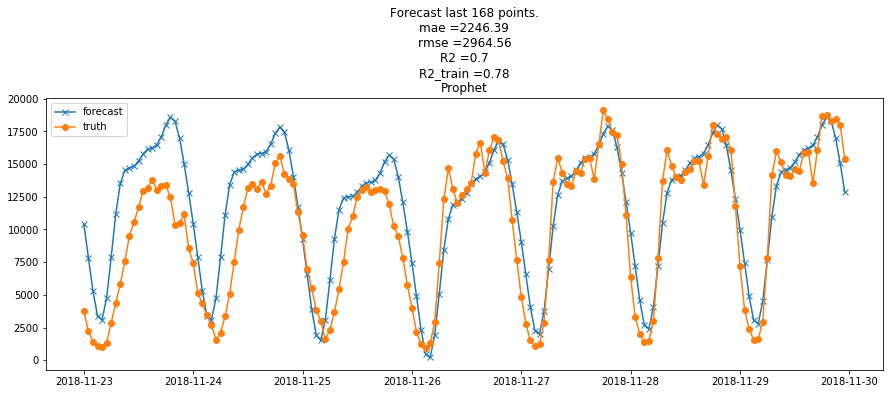

In [119]:
plot_forecast(test, forecast, train, train_pred, num_pounts_to_pred)

Trends and seasonal components of the model

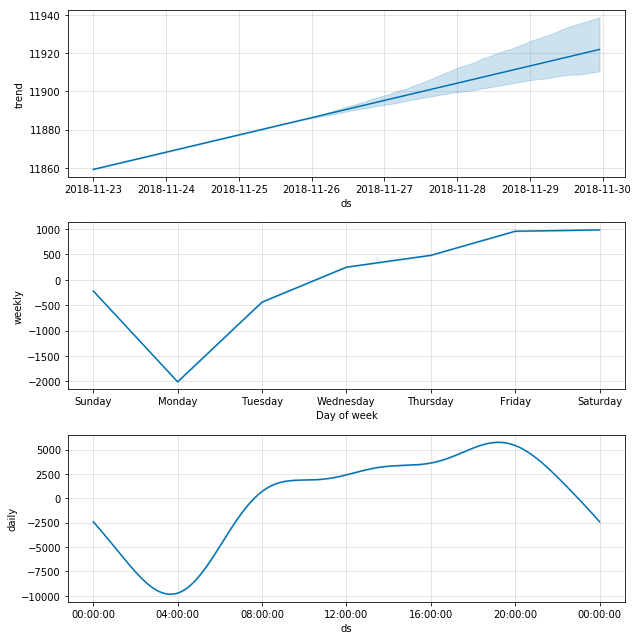

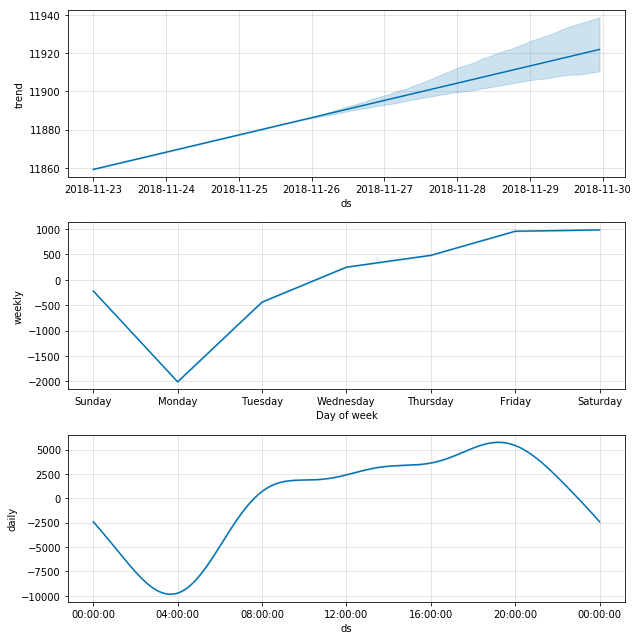

In [120]:
m.plot_components(forecast)

Plotting forecast using FB Prophet plot feature

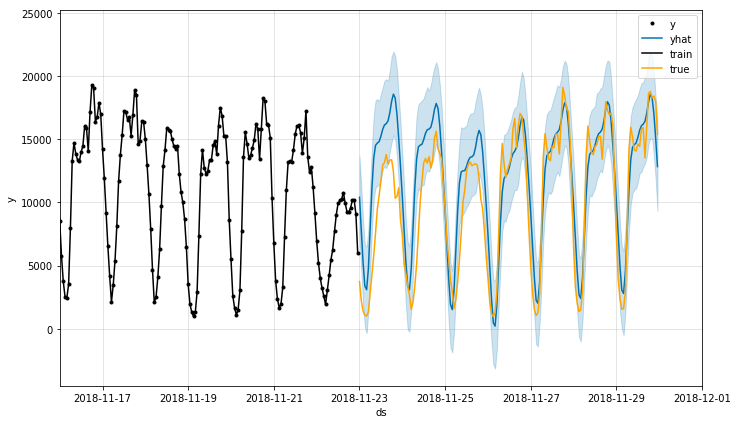

In [123]:
m.plot(forecast)
plt.plot(train.ds, train.y, label = 'train', c = 'black')
plt.plot(test.ds, test.y, label = 'true', c='orange')
plt.xlim('2018-11-16','2018-12')
plt.legend()

First attempt seems to give good results. To verify if model is performing well for whole dataset I will perform time series cross validation by splitting the data into 5 datapoints and fitting model to only historical values for each point.

In [170]:
def ts_cv(df, nfolds, periods = 168, freq='h', include_holidays = True, add_regressors = False):
    
    # splitting the datapoints
    tscv = TimeSeriesSplit(n_splits=nfolds)
    results = []
    df = df.reset_index()
    for train_index, test_index in tqdm_notebook(tscv.split(df)):
        train, test = df.loc[train_index], df.loc[test_index]
        
        # adding US holidays and including seasonality
        if include_holidays:
            model = Prophet(holidays=hol,yearly_seasonality=False, weekly_seasonality= True, daily_seasonality=True )
        else:
            model = Prophet(yearly_seasonality=False, weekly_seasonality= True, daily_seasonality=True)

        num_pounts_to_pred = freq
        
        # adding additional regressors - exogenous variables
        if add_regressors!= False:
            for reg in add_regressors:
                model.add_regressor(reg)

        # fitting the model
        model.fit(train)
        future = model.make_future_dataframe(periods=periods, freq=freq, include_history=False)

        if add_regressors!= False:
            for reg in add_regressors:
                future[reg] = test.reset_index()[reg]
                future = future.fillna(method = 'ffill')
        
        # predicting the future for current split
        forecast = model.predict(future)
        train_pred = model.predict(train)
        
        scoreR2 = r2_score(test[:periods].y, forecast.yhat)
        scoreR2_train = r2_score(train.y, train_pred.yhat)
        scoreRMSE = np.sqrt(mse(test[:periods].y, forecast.yhat))
        
        # saving all accuracy metrics and models
        results.append((train, test[:periods], forecast, train_pred, model, scoreR2_train, scoreR2, scoreRMSE))
    return results

In [171]:
res = ts_cv(demand_fb, nfolds = 5, periods = 168, freq='h', include_holidays = False, add_regressors = False)
np.mean([x[-3] for x in res]), np.mean([x[-2] for x in res]), np.mean([x[-1] for x in res])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.7784777832508857, 0.6624596239381573, 2896.825691167892)

#### Baseline model - R2_train = 0.778, R2_test = 0.662, RMSE = 2897

RMSE score for each validation

In [172]:
[x[-1] for x in res]

[3059.6279948683377,
 2448.2314316555266,
 3713.6293682030187,
 2712.064364956584,
 2550.5752961559906]

Predictions for last split

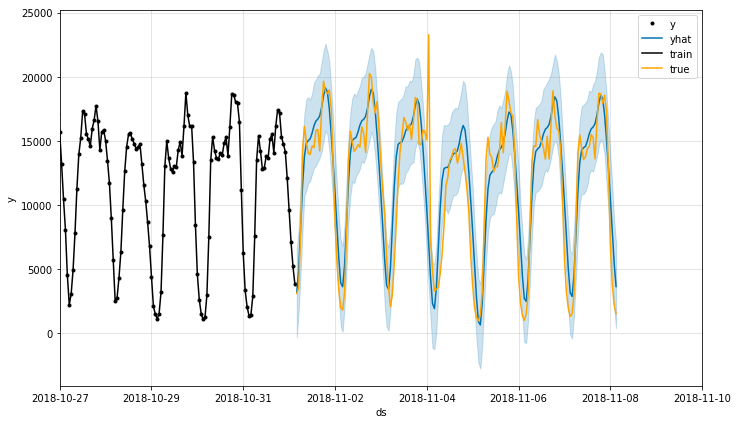

In [357]:
res[-1][4].plot(res[-1][2])
plt.plot(res[-1][0].ds, res[-1][0].y, label = 'train', c = 'black')
plt.plot(res[-1][1].ds, res[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.legend()

### Creating holidays dataframe

Importing US holidays for 2018

In [135]:
cal = calendar()
holidays = cal.holidays(start='2018-01-01', end='2018-12-31')

In [136]:
demand_fb['date'] = demand_fb.ds.apply(lambda x: x.date())

In [137]:
demand_fb['holiday'] = np.where(pd.to_datetime(demand_fb.date).isin(holidays), 1, 0)

Creating dataframe with holidays

In [138]:
hol = demand_fb.drop(['y', 'date'], axis = 1).copy()

In [139]:
hol = hol[hol.holiday != 0]

In [140]:
hol.holiday = hol.holiday.astype('str')

In [141]:
hol.holiday = 'holiday'

### Demand forecast - adding holidays

In [143]:
res = ts_cv(demand_fb, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = False)
np.mean([x[-3] for x in res]), np.mean([x[-2] for x in res]), np.mean([x[-1] for x in res])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


(0.7791877535390311, 0.673282254818478, 2872.2436567786112)

#### Holiday model - R2_train = 0.779, R2_test = 0.673, RMSE = 2872

RMSE score for each validation

In [161]:
[x[-1] for x in res]

[3061.078660494498,
 2448.9184715470997,
 3576.9149245923363,
 2717.085113080083,
 2557.22111417904]

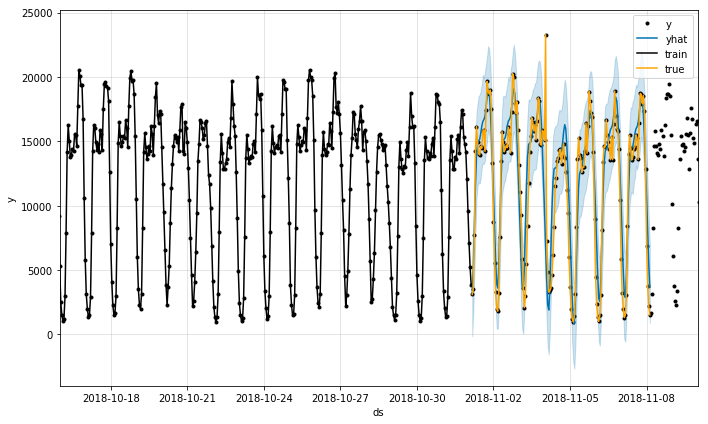

In [160]:
m.plot(res[-1][2])
plt.plot(res[-1][0].ds, res[-1][0].y, label = 'train', c = 'black')
plt.plot(res[-1][1].ds, res[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-16','2018-11-10')
plt.legend()

### Demand forecast - adding exogenous variables

In [173]:
exog = pd.read_csv('gcs://nyc-taxi-data-2018-2019/date_weather_bike_hr_features_2018.csv')

In [174]:
demand_fb_exog = demand_fb.copy()
demand_fb_exog = demand_fb.join(exog)

In [175]:
demand_fb_exog.head()

,ds,y,date,holiday,DATE,weekday,month,weekend,since_2018,AWND,...,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WSF2,WT01,demand,tripduration
0,2018-01-01 00:00:00,16458,2018-01-01,1,2018-01-01 00:00:00,Monday,January,0,0,17.67,...,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,119,704.831933
1,2018-01-01 01:00:00,18985,2018-01-01,1,2018-01-01 01:00:00,Monday,January,0,0,17.67,...,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,168,1298.660714
2,2018-01-01 02:00:00,16561,2018-01-01,1,2018-01-01 02:00:00,Monday,January,0,0,17.67,...,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,98,539.020408
3,2018-01-01 03:00:00,12611,2018-01-01,1,2018-01-01 03:00:00,Monday,January,0,0,17.67,...,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,72,647.138889
4,2018-01-01 04:00:00,8726,2018-01-01,1,2018-01-01 04:00:00,Monday,January,0,0,17.67,...,0.0,0.0,12.0,18.0,7.0,310.0,29.1,0.0,34,502.205882


In [181]:
demand_fb_exog = pd.get_dummies(demand_fb_exog.drop(['DATE', 'date'], axis=1))

In [187]:
demand_fb_exog_scaled = demand_fb_exog.copy()

Scaling exogenous variables

In [131]:
scaler = StandardScaler()

In [206]:
scaler = StandardScaler()demand_fb_exog_scaled['PRCP'] = scaler.fit_transform(pd.DataFrame(demand_fb_exog.PRCP))
demand_fb_exog_scaled['TAVG'] = scaler.fit_transform(pd.DataFrame(demand_fb_exog.TAVG))
demand_fb_exog_scaled['SNOW'] = scaler.fit_transform(pd.DataFrame(demand_fb_exog.SNOW))
demand_fb_exog_scaled['since_2018'] = scaler.fit_transform(pd.DataFrame(demand_fb_exog.since_2018))
demand_fb_exog_scaled['demand'] = scaler.fit_transform(pd.DataFrame(demand_fb_exog.demand))

Correlation for demand

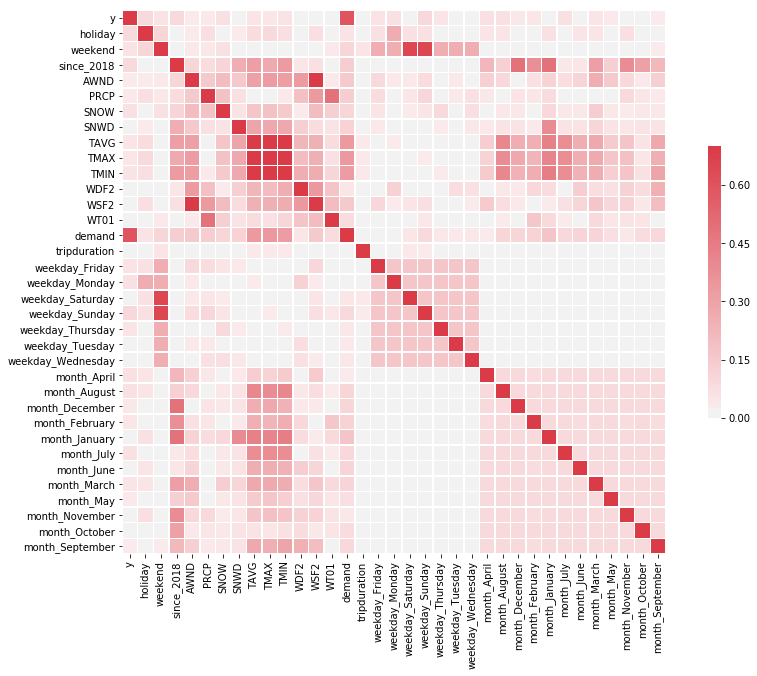

In [219]:
plt.figure(figsize = (15,10))
sns.heatmap(abs(demand_fb_exog.corr()),  cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regressors: weekend + since_2018

In [209]:
res_1 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018'])
np.mean([x[-2] for x in res_1]), np.mean([x[-1] for x in res_1])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6812360358099403, 2837.5973640015272)

In [210]:
np.mean([x[-3] for x in res_1]),np.mean([x[-2] for x in res_1]), np.mean([x[-1] for x in res_1])

(0.7854029956445137, 0.6812360358099403, 2837.5973640015272)

#### Res_1 model - R2_train = 0.785, R2_test = 0.681, RMSE = 2837

RMSE score for each validation

In [211]:
[x[-1] for x in res_1]

[3017.9966702070788,
 2413.0879765072423,
 3526.5793837398223,
 2711.230929924288,
 2519.0918596292054]

Prediction for last split

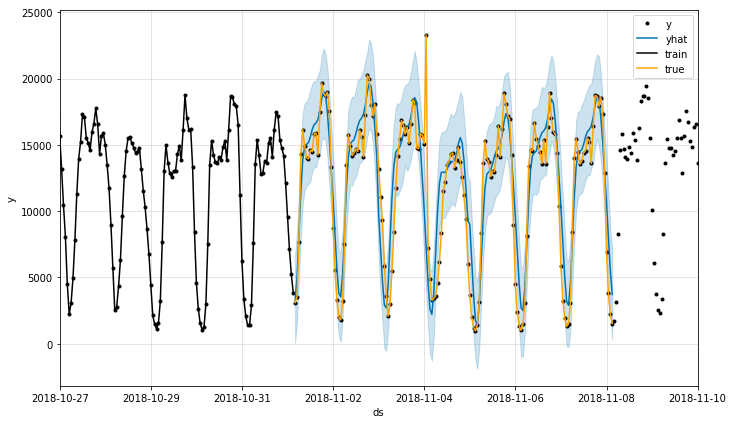

In [353]:
m.plot(res_1[-1][2])
plt.plot(res_1[-1][0].ds, res_1[-1][0].y, label = 'train', c = 'black')
plt.plot(res_1[-1][1].ds, res_1[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.legend()

### Regressors: weekend, since_2018, CityBike demand

In [ ]:
res_2 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018', 'demand'])
np.mean([x[-3] for x in res_2]),np.mean([x[-2] for x in res_2]), np.mean([x[-1] for x in res_2])


/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.8114069067596894, 0.7224637969204093, 2635.265634497353)

#### Res_2 model - R2_train = 0.811, R2_test = 0.722, RMSE = 2635

### Regressors: weather - snow, average temperature, fog

In [224]:
res_3 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_3]),np.mean([x[-2] for x in res_3]), np.mean([x[-1] for x in res_3])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.7923071593272077, 0.6832841230805247, 2820.075308564311)

#### Res_3 model - R2_train = 0.792, R2_test = 0.683, RMSE = 2820

### Regressors: weekend, since_2018, CityBike demand, snow, average temperature, fog

In [225]:
res_4 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018', 'demand','SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_4]),np.mean([x[-2] for x in res_4]), np.mean([x[-1] for x in res_4])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.8223597436924681, 0.7261550461465985, 2600.2815464740906)

#### Res_4 model - R2_train = 0.822, R2_test = 0.726, RMSE = 2600

### Regressors: weekend, since_2018, snow, average temperature, fog

In [226]:
res_5 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018', 'SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_5]),np.mean([x[-2] for x in res_5]), np.mean([x[-1] for x in res_5])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.7985175055437965, 0.6903753929094963, 2784.647735739015)

### Regressors: CityBike demand

In [227]:
res_6 = ts_cv(demand_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['demand'])
np.mean([x[-3] for x in res_6]),np.mean([x[-2] for x in res_6]), np.mean([x[-1] for x in res_6])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.8065010146907211, 0.7171367997913373, 2660.1645302774864)

### Best performing model for NYC yellow taxi pickup demand - weekend, CityBike demand, weather

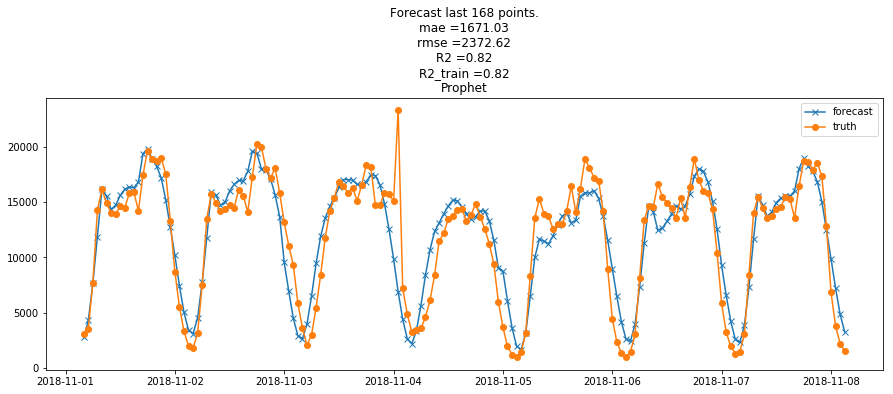

In [331]:
plot_forecast(test = res_4[-1][1], forecast = res_4[-1][2], train = res_4[-1][0], train_pred = res_4[-1][3], num_pounts_to_pred = num_pounts_to_pred)

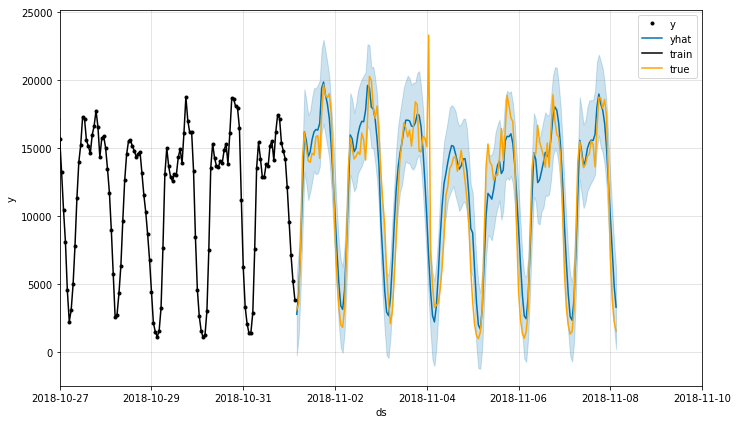

In [334]:
res_4[-1][4].plot(res_4[-1][2])
plt.plot(res_4[-1][0].ds, res_4[-1][0].y, label = 'train', c = 'black')
plt.plot(res_4[-1][1].ds, res_4[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')

plt.legend()

## Average fare forecast

In [228]:
fare = data_hr_2018.fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute()

In [231]:
fare_fb = fare.reset_index()
fare_fb.columns = ['ds', 'y']
fare_fb

,ds,y
0,2018-01-01 00:00:00,12.621758
1,2018-01-01 01:00:00,12.864467
2,2018-01-01 02:00:00,12.988859
3,2018-01-01 03:00:00,12.950800
4,2018-01-01 04:00:00,13.898338
...,...,...
8747,2018-12-31 19:00:00,11.334596
8748,2018-12-31 20:00:00,11.352768
8749,2018-12-31 21:00:00,11.904043
8750,2018-12-31 22:00:00,12.047465


### Baseline model for fare prediction

In [232]:
res_fare_1 = ts_cv(fare_fb, nfolds = 5, periods = 168, freq='h', include_holidays = False, add_regressors = False)
np.mean([x[-3] for x in res_fare_1]), np.mean([x[-2] for x in res_fare_1]), np.mean([x[-1] for x in res_fare_1])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.41175560361291, 0.2432658271574634, 1.3230404603743446)

#### Res_fare_1 model - R2_train = 0.411, R2_test = 0.243, RMSE = 1.32

Trends and seasonalities in last split model

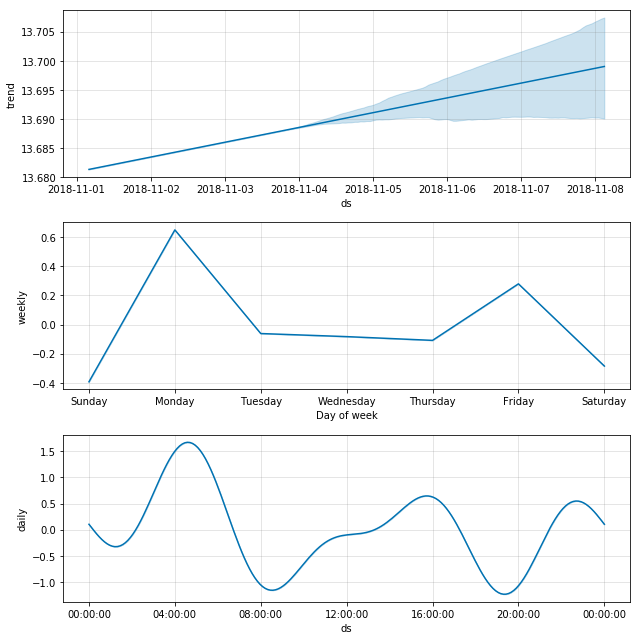

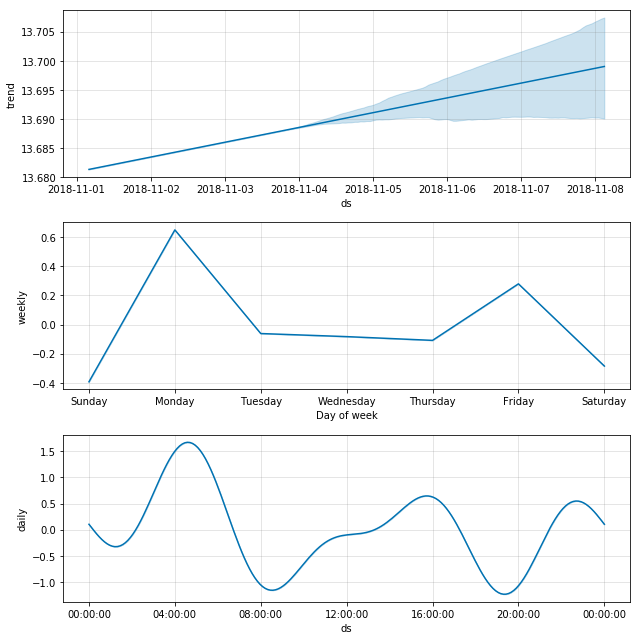

In [344]:
res_fare_1[-1][4].plot_components(res_fare_1[-1][2])

Last split predictions

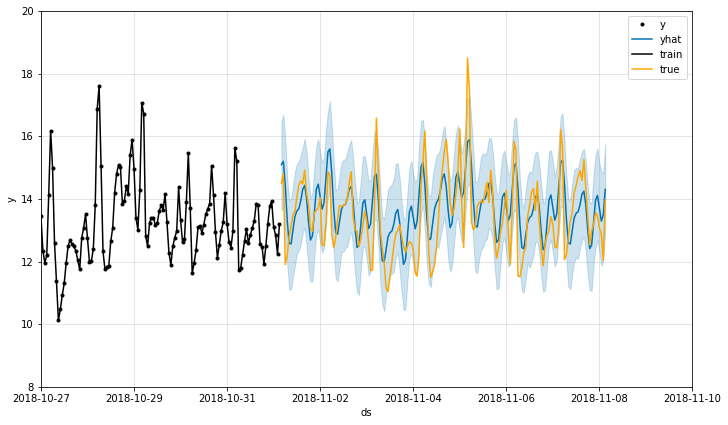

In [345]:
res_fare_1[-1][4].plot(res_fare_1[-1][2])
plt.plot(res_fare_1[-1][0].ds, res_fare_1[-1][0].y, label = 'train', c = 'black')
plt.plot(res_fare_1[-1][1].ds, res_fare_1[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.ylim(8,20)
plt.legend()

### Fare forecast - adding holidays

In [233]:
res_fare_2 = ts_cv(fare_fb, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = False)
np.mean([x[-3] for x in res_fare_2]), np.mean([x[-2] for x in res_fare_2]), np.mean([x[-1] for x in res_fare_2])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.41231858494880014, 0.2407982574099206, 1.3252652546569696)

#### Res_fare_2 model - R2_train = 0.412, R2_test = 0.241, RMSE = 1.33

### Fare forecast - adding exogenous variables

In [236]:
exog = pd.get_dummies(exog.drop(['DATE'], axis=1))

In [243]:
fare_fb_exog = fare_fb.copy()
fare_fb_exog = fare_fb_exog.join(exog)

Scaling data

In [244]:
fare_fb_exog_scaled = fare_fb_exog.copy()

In [245]:
fare_fb_exog_scaled['PRCP'] = scaler.fit_transform(pd.DataFrame(fare_fb_exog.PRCP))
fare_fb_exog_scaled['TAVG'] = scaler.fit_transform(pd.DataFrame(fare_fb_exog.TAVG))
fare_fb_exog_scaled['SNOW'] = scaler.fit_transform(pd.DataFrame(fare_fb_exog.SNOW))
fare_fb_exog_scaled['since_2018'] = scaler.fit_transform(pd.DataFrame(fare_fb_exog.since_2018))
fare_fb_exog_scaled['demand'] = scaler.fit_transform(pd.DataFrame(fare_fb_exog.demand))

Features' correlations

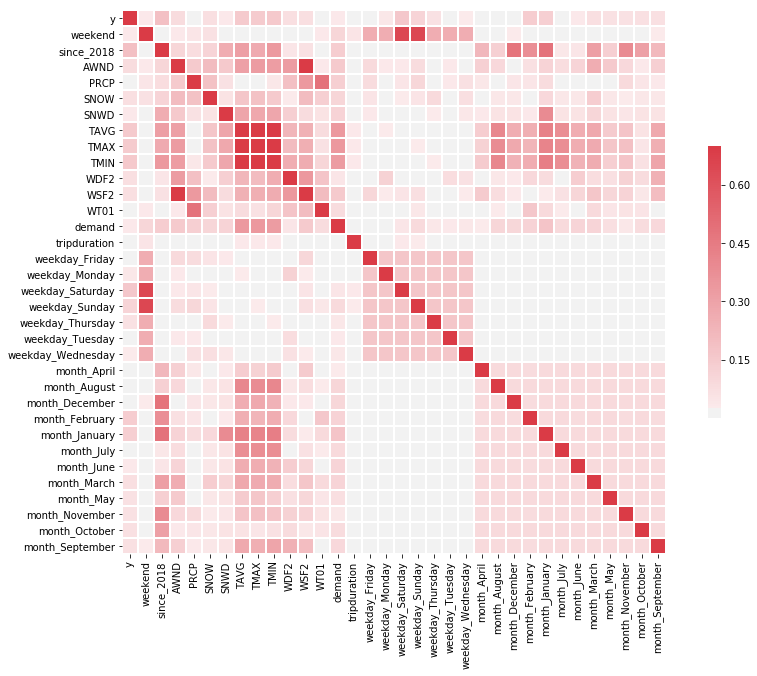

In [247]:
plt.figure(figsize=(15,10))
sns.heatmap(abs(fare_fb_exog.corr()),  cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regressors: weekend, since_2018, CityBike demand, snow, average temperature, fog

In [248]:
res_fare_3 = ts_cv(fare_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018', 'demand','SNOW', 'WT01', 'TAVG'])
np.mean([x[-2] for x in res_fare_3]), np.mean([x[-1] for x in res_fare_3])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.24250195726136203, 1.3237521769482359)

In [249]:
np.mean([x[-3] for x in res_fare_3]), np.mean([x[-2] for x in res_fare_3]), np.mean([x[-1] for x in res_fare_3])

(0.43536929589211654, 0.24250195726136203, 1.3237521769482359)

#### Res_fare_3 model - R2_train = 0.435, R2_test = 0.242, RMSE = 1.32

RMSE score for each validation

In [250]:
[x[-1] for x in res_fare_3]

[1.5127691402142183,
 1.5380287457274813,
 1.3045327026851803,
 1.350529834016409,
 0.9129004620978899]

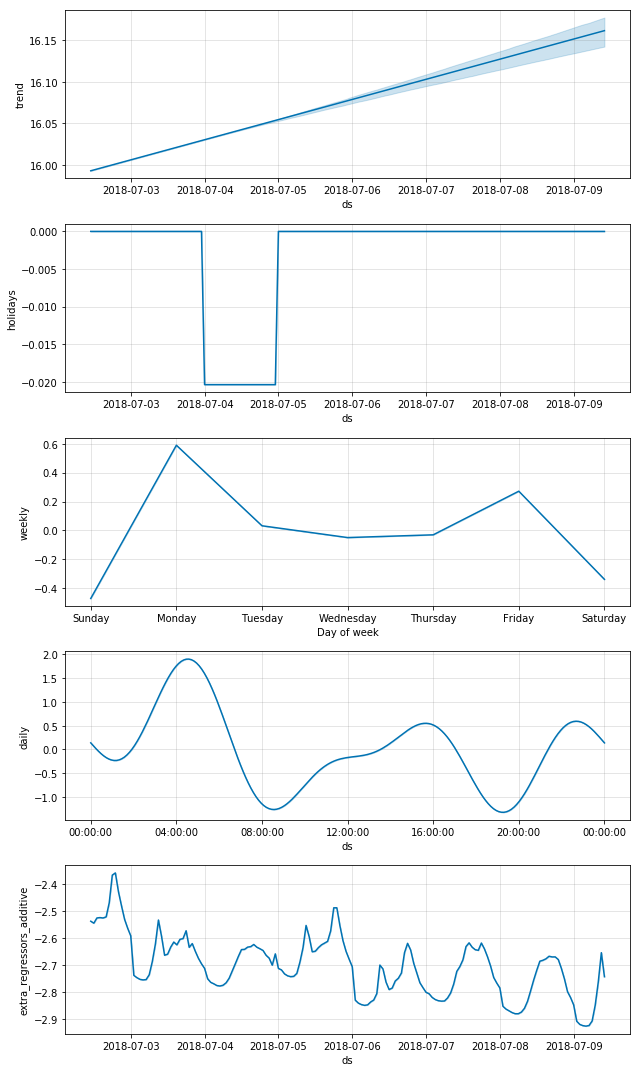

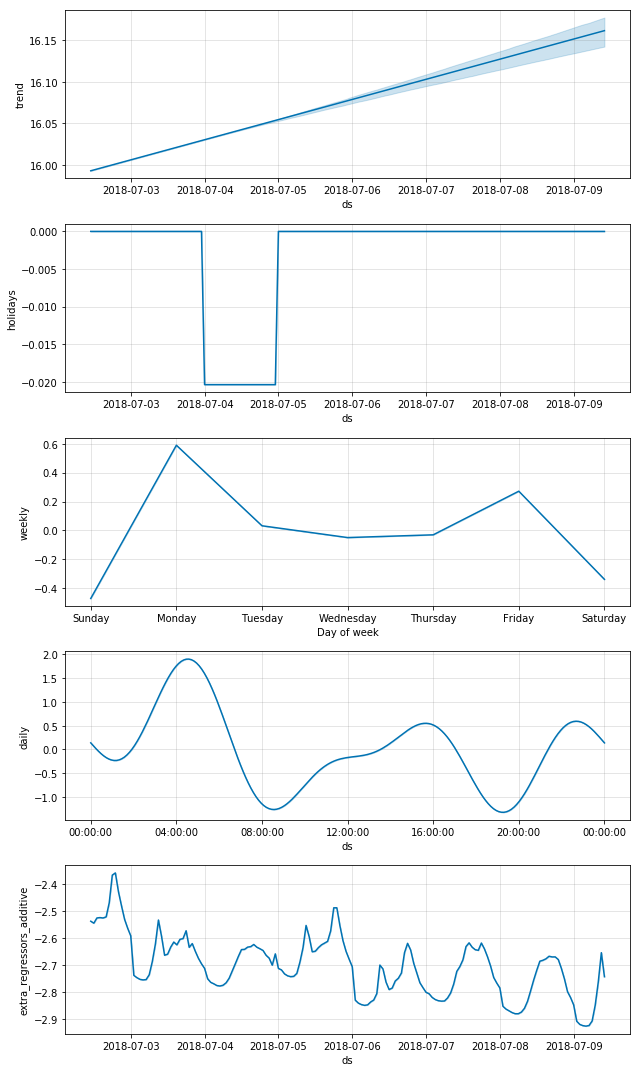

In [252]:
res_fare_3[-3][4].plot_components(res_fare_3[-3][2])

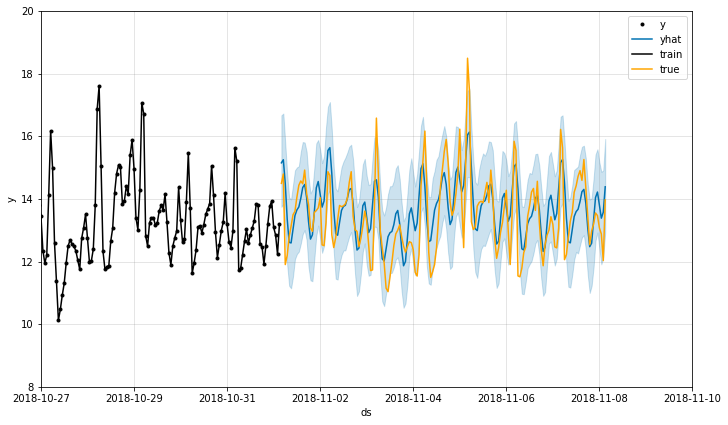

In [265]:
res_fare_3[-1][4].plot(res_fare_3[-1][2])
plt.plot(res_fare_3[-1][0].ds, res_fare_3[-1][0].y, label = 'train', c = 'black')
plt.plot(res_fare_3[-1][1].ds, res_fare_3[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.ylim(8,20)
plt.legend()

### Regressors: weekday, month

In [267]:
res_fare_4 = ts_cv(fare_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September'])
np.mean([x[-3] for x in res_fare_4]), np.mean([x[-2] for x in res_fare_4]), np.mean([x[-1] for x in res_fare_4])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.4244145274242978, -0.08193884613197448, 1.5271116620090752)

#### Res_fare_4 model - R2_train = 0.424, R2_test = -0.08, RMSE = 1.53

### Regressors: weekend, since_2018, CityBike demand

In [271]:
res_fare_5 = ts_cv(fare_fb_exog_scaled, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'since_2018', 'demand'])
np.mean([x[-3] for x in res_fare_5]), np.mean([x[-2] for x in res_fare_5]), np.mean([x[-1] for x in res_fare_5])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.4146707151770495, 0.24843938396594528, 1.3187279342066969)

#### Res_fare_5 model - R2_train = 0.415, R2_test = 0.248, RMSE = 1.32

### Best performing model for NYC yellow taxi average fare- weekend, CityBike demand, since_2018

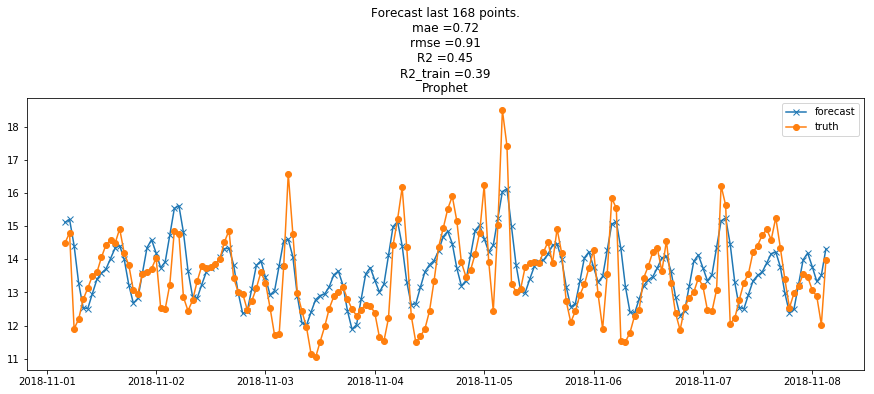

In [327]:
plot_forecast(test = res_fare_5[-1][1], forecast = res_fare_5[-1][2], train = res_fare_5[-1][0], train_pred = res_fare_5[-1][3], num_pounts_to_pred = num_pounts_to_pred)

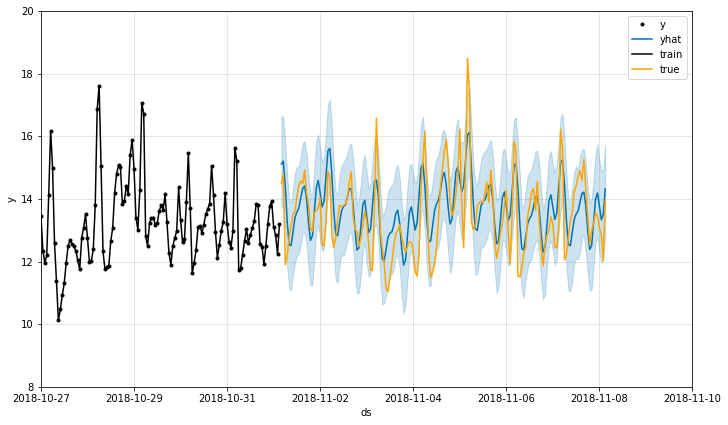

In [330]:
Last split predictionsres_fare_5[-1][4].plot(res_fare_5[-1][2])
plt.plot(res_fare_5[-1][0].ds, res_fare_5[-1][0].y, label = 'train', c = 'black')
plt.plot(res_fare_5[-1][1].ds, res_fare_5[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.ylim(8,20)
plt.legend()

## Tip ratio forecasts

In [273]:
tip_ratio = data_hr_2018.tip_ratio_avg.compute()

In [276]:
tip_ratio_fb = tip_ratio.reset_index()
tip_ratio_fb.columns = ['ds', 'y']
tip_ratio_fb

,ds,y
0,2018-01-01 00:00:00,0.094985
1,2018-01-01 01:00:00,0.099037
2,2018-01-01 02:00:00,0.098159
3,2018-01-01 03:00:00,0.094318
4,2018-01-01 04:00:00,0.083468
...,...,...
8755,2018-12-31 19:00:00,0.098953
8756,2018-12-31 20:00:00,0.097243
8757,2018-12-31 21:00:00,0.097260
8758,2018-12-31 22:00:00,0.092727


### Baseline model for tip prediction

In [ ]:
res_tip_1 = ts_cv(tip_ratio_fb, nfolds = 5, periods = 168, freq='h', include_holidays = False, add_regressors = False)
np.mean([x[-3] for x in res_tip_1]), np.mean([x[-2] for x in res_tip_1]), np.mean([x[-1] for x in res_tip_1])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6868129111121982, 0.4520752369023165, 0.006981641659859294)

#### Baseline tip model - R2_train = 0.687, R2_test = 0.452, RMSE = 0.007

Trends and seasonalities in last split model

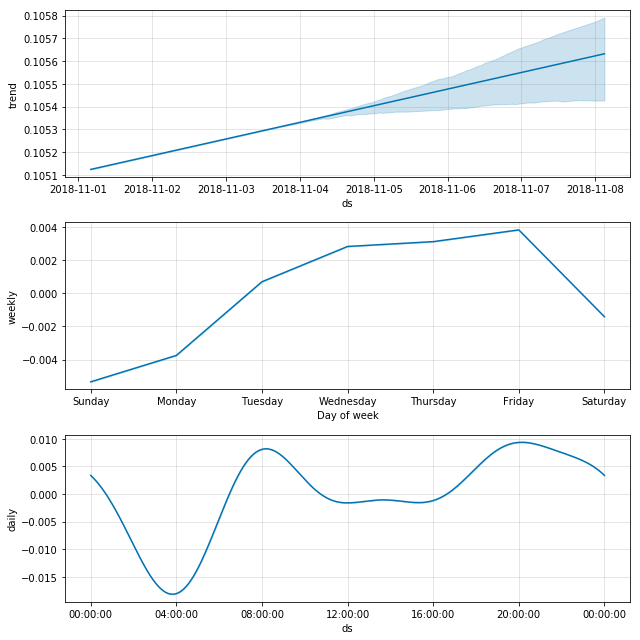

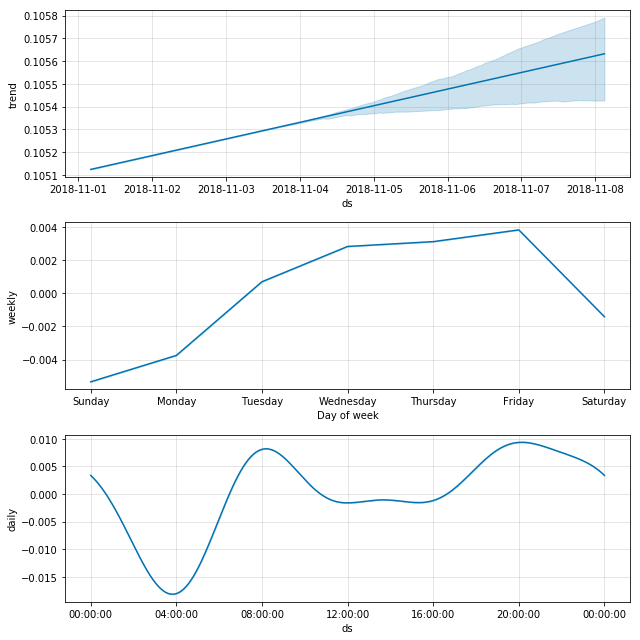

In [351]:
res_tip_1[-1][4].plot_components(res_tip_1[-1][2])

Last split predictions

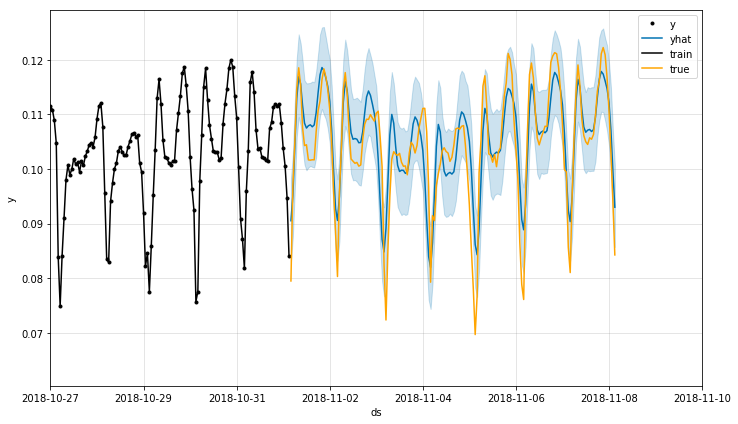

In [352]:
res_tip_1[-1][4].plot(res_tip_1[-1][2])
plt.plot(res_tip_1[-1][0].ds, res_tip_1[-1][0].y, label = 'train', c = 'black')
plt.plot(res_tip_1[-1][1].ds, res_tip_1[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.legend()

### Tip forecast - adding holidays

In [279]:
res_tip_2 = ts_cv(tip_ratio_fb, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = False)
np.mean([x[-3] for x in res_tip_2]),np.mean([x[-2] for x in res_tip_2]), np.mean([x[-1] for x in res_tip_2])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6873994824562238, 0.46732522947898403, 0.006919876628546977)

#### Res_tip_2 model - R2_train = 0.687, R2_test = 0.467, RMSE = 0.007

### Tip ratio forecast - adding exogenous variables

In [281]:
tip_ratio_fb_exog = tip_ratio_fb.copy()
tip_ratio_fb_exog = tip_ratio_fb.join(exog)

Features' correlations

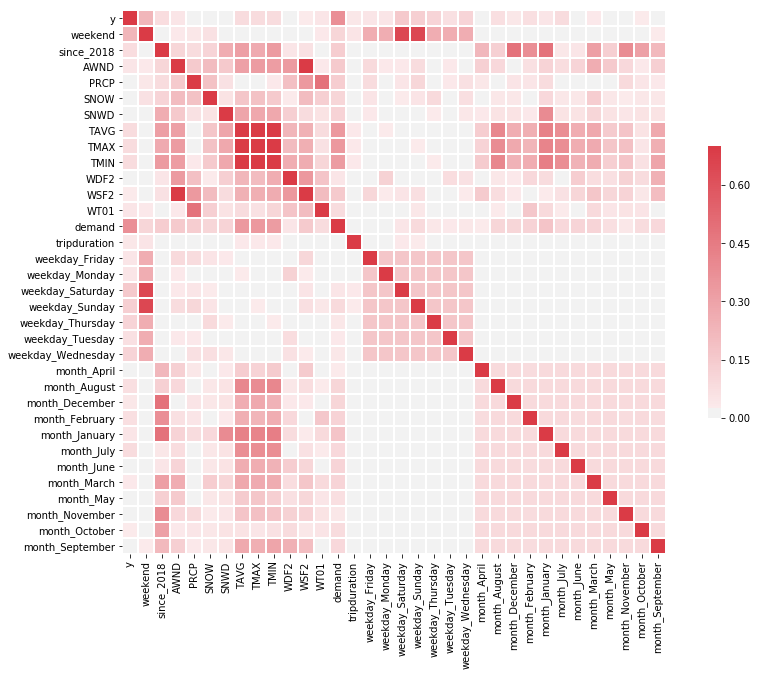

In [284]:
plt.figure(figsize = (15,10))
sns.heatmap(abs(tip_ratio_fb_exog.corr()),  cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regressors: CityBike demand

In [286]:
res_tip_3 = ts_cv(tip_ratio_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['demand'])
np.mean([x[-3] for x in res_tip_3]),np.mean([x[-2] for x in res_tip_3]), np.mean([x[-1] for x in res_tip_3])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.7031887974018549, 0.5043682370661169, 0.006700610645139412)

#### Res_tip_3 model - R2_train = 0.703, R2_test = 0.504, RMSE = 0.007

### Regressors: weekend, CityBike demand

In [287]:
res_tip_4 = ts_cv(tip_ratio_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend','demand'])
np.mean([x[-3] for x in res_tip_4]),np.mean([x[-2] for x in res_tip_4]), np.mean([x[-1] for x in res_tip_4])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.7068250969958714, 0.5020205674416448, 0.006703314540061195)

#### Res_tip_4 model - R2_train = 0.707, R2_test = 0.502, RMSE = 0.007

### Regressors: weekend, since_2018, CityBike demand, snow, average temperature, fog

In [288]:
res_tip_5 = ts_cv(tip_ratio_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekend', 'demand', 'since_2018', 'SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_tip_5]),np.mean([x[-2] for x in res_tip_5]), np.mean([x[-1] for x in res_tip_5])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.712647039891935, 0.5093896887387425, 0.006645557027499005)

#### Res_tip_5 model - R2_train = 0.712, R2_test = 0.509, RMSE = 0.007

### Regressors: weekday, month

In [ ]:
res_tip_6 = ts_cv(tip_ratio_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September'])

In [290]:
np.mean([x[-3] for x in res_tip_6]), np.mean([x[-2] for x in res_tip_6]), np.mean([x[-1] for x in res_tip_6])

(0.7271049242841242, 0.5822526247133968, 0.006448222332061637)

#### Res_tip_6 model - R2_train = 0.727, R2_test = 0.582, RMSE = 0.006

### Regressors: weekday, month, weekend, since_2018, CityBike demand, snow, average temperature, fog

In [291]:
res_tip_7 = ts_cv(tip_ratio_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September','weekend', 'demand', 'since_2018', 'SNOW', 'WT01', 'TAVG'])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



In [292]:
np.mean([x[-3] for x in res_tip_7]), np.mean([x[-2] for x in res_tip_7]), np.mean([x[-1] for x in res_tip_7])

(0.7458295383769803, 0.6061669055094565, 0.006190608676721389)

#### Res_tip_7 model - R2_train = 0.745, R2_test = 0.606, RMSE = 0.006

### Best performing model for NYC yellow taxi driver tips - weekday, month, CityBike demand, weather

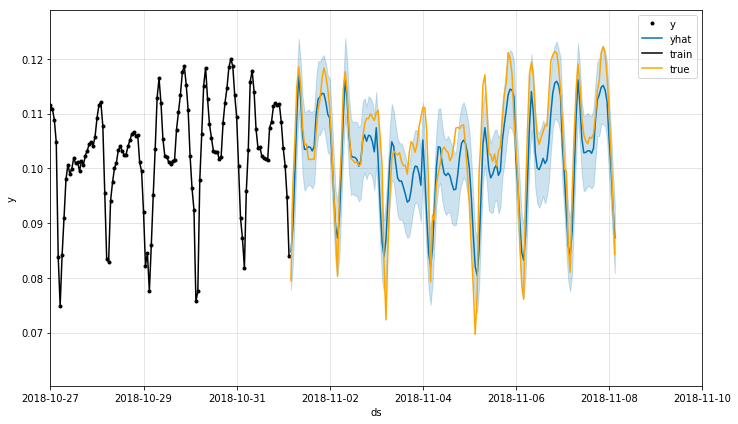

In [326]:
res_tip_7[-1][4].plot(res_tip_7[-1][2])
plt.plot(res_tip_7[-1][0].ds, res_tip_7[-1][0].y, label = 'train', c = 'black')
plt.plot(res_tip_7[-1][1].ds, res_tip_7[-1][1].y, label = 'true', c='orange')
plt.xlim('2018-10-27','2018-11-10')
plt.legend()

## Trip distance forecasts

In [293]:
trip_hr = data_hr_2018.trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute()

In [296]:
trip_hr_fb = trip_hr.reset_index()
trip_hr_fb.columns = ['ds', 'y']
trip_hr_fb

,ds,y
0,2018-01-01 00:00:00,2.754618
1,2018-01-01 01:00:00,2.957461
2,2018-01-01 02:00:00,3.083759
3,2018-01-01 03:00:00,3.167346
4,2018-01-01 04:00:00,3.562889
...,...,...
8754,2018-12-31 19:00:00,2.562049
8755,2018-12-31 20:00:00,2.548474
8756,2018-12-31 21:00:00,2.707601
8757,2018-12-31 22:00:00,2.883919


### Baseline model for trip distance prediction

In [298]:
res_trip_1 = ts_cv(trip_hr_fb, nfolds = 5, periods = 168, freq='h', include_holidays = False, add_regressors = False)
np.mean([x[-3] for x in res_trip_1]), np.mean([x[-2] for x in res_trip_1]), np.mean([x[-1] for x in res_trip_1])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6616033529015741, 0.6310536574534197, 0.3755569346895079)

#### Baseline trip distance model - R2_train = 0.662, R2_test = 0.631, RMSE = 0.376

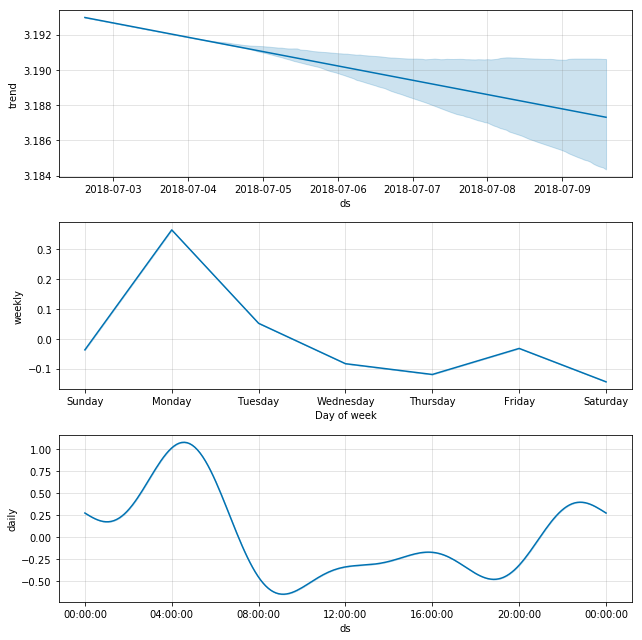

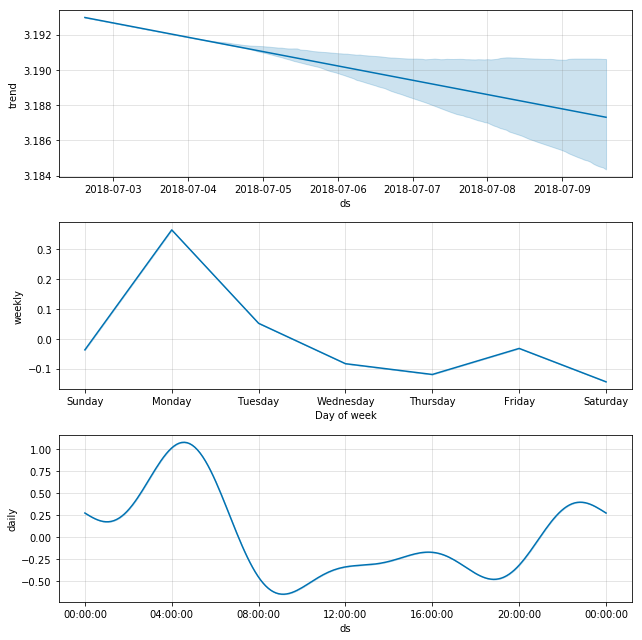

In [348]:
res_trip_1[-3][4].plot_components(res_trip_1[-3][2])

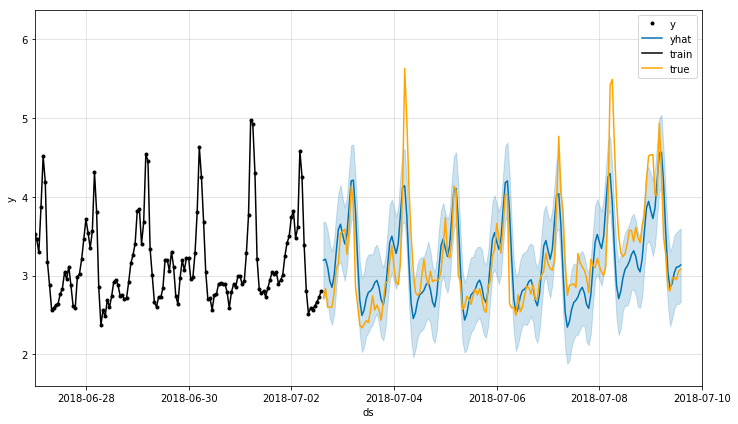

In [349]:
res_trip_1[-3][4].plot(res_trip_1[-3][2])
plt.plot(res_trip_1[-3][0].ds, res_trip_1[-3][0].y, label = 'train', c = 'black')
plt.plot(res_trip_1[-3][1].ds, res_trip_1[-3][1].y, label = 'true', c='orange')
plt.xlim('2018-06-27','2018-07-10')
plt.legend()

### Trip distance forecast - adding holidays

In [299]:
res_trip_2 = ts_cv(trip_hr_fb, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = False)
np.mean([x[-3] for x in res_trip_2]), np.mean([x[-2] for x in res_trip_2]), np.mean([x[-1] for x in res_trip_2])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6627256731220816, 0.6412240400210291, 0.3706507523224257)

#### Res_trip_2 model - R2_train = 0.663, R2_test = 0.641, RMSE = 0.371

### Trip distance forecast - adding exogenous variables

In [300]:
trip_hr_fb_exog = trip_hr_fb.copy()
trip_hr_fb_exog = trip_hr_fb_exog.join(exog)

Features' correlations

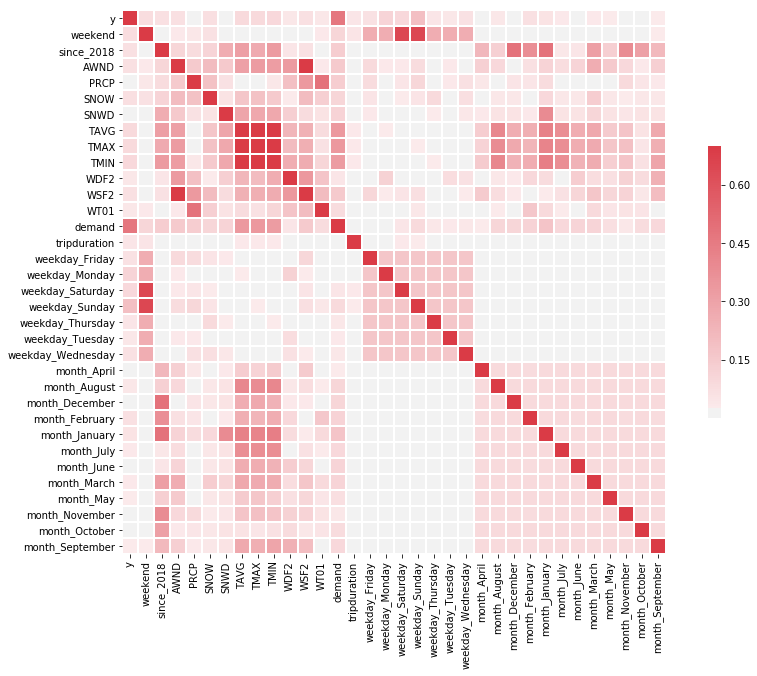

In [302]:
plt.figure(figsize = (15,10))
sns.heatmap(abs(trip_hr_fb_exog.corr()),  cmap=sns.diverging_palette(220, 10, as_cmap=True), vmax=.7, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Regressors: CityBike demand

In [303]:
res_trip_3 = ts_cv(trip_hr_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['demand'])
np.mean([x[-3] for x in res_trip_3]), np.mean([x[-2] for x in res_trip_3]), np.mean([x[-1] for x in res_trip_3])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6630033145936416, 0.6410428545227326, 0.3707466350921736)

#### Res_trip_3 model - R2_train = 0.663, R2_test = 0.641, RMSE = 0.371

### Regressors: weekend, CityBike demand

In [304]:
res_trip_4 = ts_cv(trip_hr_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['demand', 'weekend'])
np.mean([x[-3] for x in res_trip_4]), np.mean([x[-2] for x in res_trip_4]), np.mean([x[-1] for x in res_trip_4])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6719034076901768, 0.6484978863999856, 0.3667088613601746)

#### Res_trip_4 model - R2_train = 0.672, R2_test = 0.648, RMSE = 0.367

### Regressors: weekday, month, weekend, since_2018, CityBike demand, snow, average temperature, fog

In [305]:
res_trip_5 = ts_cv(trip_hr_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'month_April', 'month_August', 'month_December',
       'month_February', 'month_January', 'month_July', 'month_June',
       'month_March', 'month_May', 'month_November', 'month_October',
       'month_September','weekend', 'demand', 'since_2018', 'SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_trip_5]), np.mean([x[-2] for x in res_trip_5]), np.mean([x[-1] for x in res_trip_5])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6853869228379004, 0.5928109981237989, 0.39258571917340823)

#### Res_trip_5 model - R2_train = 0.685, R2_test = 0.593, RMSE = 0.393

### Regressors: weekday, weekend, since_2018, snow, average temperature, fog

In [306]:
res_trip_6 = ts_cv(trip_hr_fb_exog, nfolds = 5, periods = 168, freq='h', include_holidays = True, add_regressors = ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weekend', 'since_2018', 'SNOW', 'WT01', 'TAVG'])
np.mean([x[-3] for x in res_trip_6]), np.mean([x[-2] for x in res_trip_6]), np.mean([x[-1] for x in res_trip_6])

/opt/conda/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



(0.6842231010789476, 0.652184992228527, 0.3643888013314968)

#### Res_trip_6 model - R2_train = 0.684, R2_test = 0.652, RMSE = 0.364

### Best performing model for NYC yellow taxi average tripi diistance - weekday, weekend, since_2018, weather

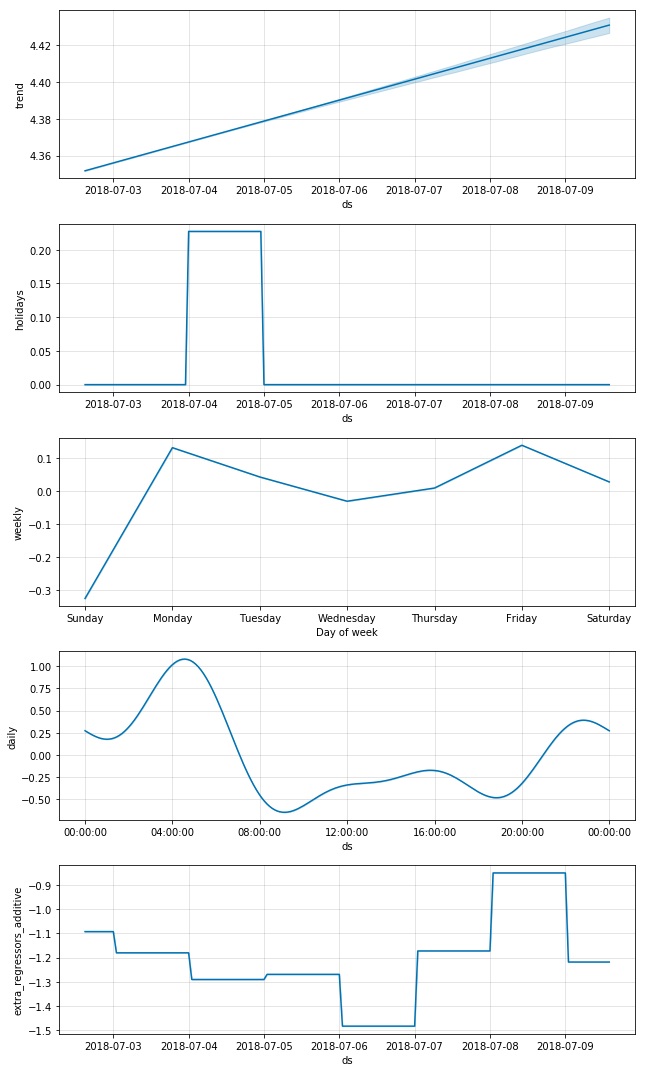

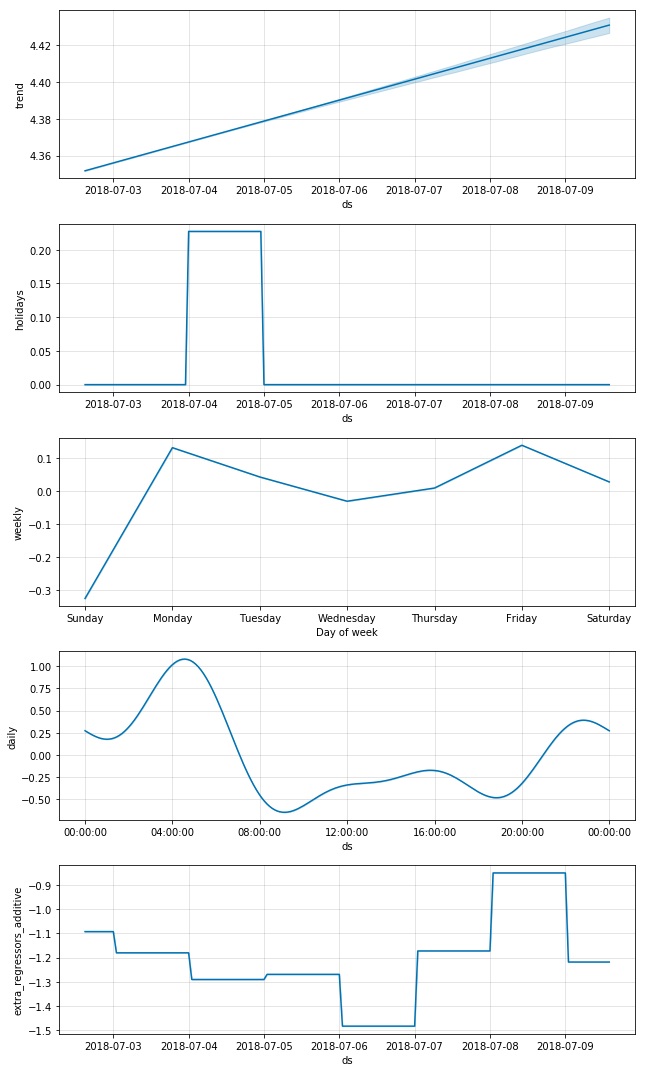

In [310]:
res_trip_6[-3][4].plot_components(res_trip_6[-3][2])

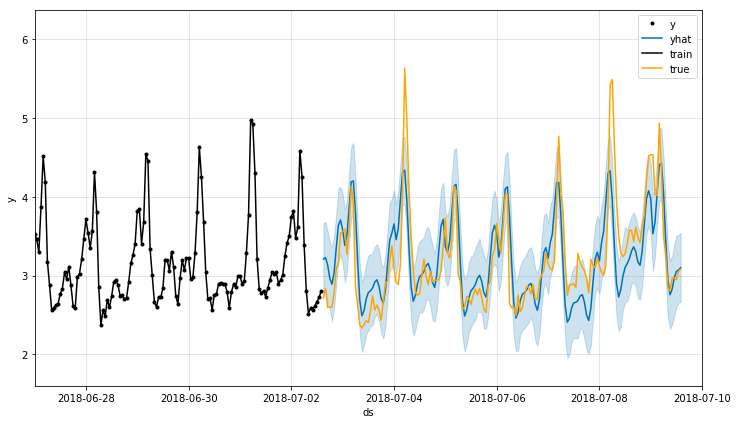

In [317]:
res_trip_6[-3][4].plot(res_trip_6[-3][2])
plt.plot(res_trip_6[-3][0].ds, res_trip_6[-3][0].y, label = 'train', c = 'black')
plt.plot(res_trip_6[-3][1].ds, res_trip_6[-3][1].y, label = 'true', c='orange')
plt.xlim('2018-06-27','2018-07-10')
plt.legend()